# Prueba de Red Neuronal Artificial con Back Propagation

## Import de librerías

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from IPython.display import display
from sklearn.cluster import KMeans
import MySQLdb
#from pandas.io import sql
#from sqlalchemy import create_engine

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

## Configuración
### Conexión al DWH

In [3]:
# Base de datos histórica
dbname_hist = "ratio_dwh"
dbhost_hist = "localhost"
dbport_hist = 3306
dbuser_hist = "root"
dbpass_hist = "root"
device_events_tbl = "device_events"
device_event_sensors_tbl = "device_event_sensors"
device_modules_tbl = "device_modules"

### Variables de configuración

In [4]:
device_id = 5                   # Device id donde esta el modulo a entrenar
lux_module_id = 51              # Modulo a entrenar

# Variables de tipos de sensores
ACS_SENSOR_TYPE = 1
LIGHT_SENSOR_TYPE = 2
MOVEMENT_SENSOR_TYPE = 3
SOUND_SENSOR_TYPE = 4
TEMP_SENSOR_TYPE = 5

### Funciones

In [5]:
# Funcion para pasar de sensor_id a nombre
def sensorIdToStr(sensor_id):
    return {
        ACS_SENSOR_TYPE: 'LUX_ACS',
        LIGHT_SENSOR_TYPE: 'LIGHT',
        MOVEMENT_SENSOR_TYPE: 'MOVEMENT',
        SOUND_SENSOR_TYPE: 'SOUND',
        TEMP_SENSOR_TYPE: 'TEMPERATURE'
    }.get(sensor_id, sensor_id)

## Extracción de datos del DWH

In [6]:
# Estrayendo valores de la tabla de eventos
conn = MySQLdb.connect(host=dbhost_hist, port=dbport_hist, user=dbuser_hist, passwd=dbpass_hist, db=dbname_hist)
from_stm = 'FROM ' + device_events_tbl + ' de LEFT JOIN ' + device_event_sensors_tbl + ' des ON de.id=des.device_event_id '
where_stm = 'WHERE device_id = ' + str(device_id) + ' AND module_id = ' + str(lux_module_id) + ' AND ts BETWEEN DATE_SUB(NOW(), INTERVAL 90 DAY) AND NOW()'
%time df_events_qry = pd.read_sql('select ts, state, sensor_type_id, value ' + from_stm + where_stm, con=conn)
conn.close()

Wall time: 12.5 s


In [7]:
df_events_qry.head(5)

,ts,state,sensor_type_id,value
0,2017-08-17 20:10:00,0,2,5.000000
1,2017-08-17 20:10:00,0,4,66.441262
2,2017-08-17 20:10:00,0,3,1.000000
3,2017-08-17 20:10:00,0,1,0.005552
4,2017-08-17 20:11:00,1,2,406.289053


### Generación de dataset para entrenamiento

In [8]:
# Se elininan los eventos de estado sin sensado
df_events_qry.dropna(inplace=True)

In [9]:
# Se "aplanan" los eventos con una tabla pivot sobre la columna sensor_type_id
df_events = df_events_qry.pivot_table(index=['ts','state'], columns='sensor_type_id', values='value', aggfunc=np.mean)
# Se elimina el multiindex de columnas generado por pivot_table
df_events = df_events.reset_index().rename_axis(None, axis=1)
# Se renombran las columnas
df_events.rename(columns={'ts': 'TIMESTAMP', 'state': 'LUX_ON'},inplace=True)
df_events.columns = [ sensorIdToStr(colname) for colname in df_events.columns ]

In [10]:
df_events.head(5)

,TIMESTAMP,LUX_ON,LUX_ACS,LIGHT,MOVEMENT,SOUND
0,2017-08-17 20:10:00,0,0.005552,5.000000,1.0,66.441262
1,2017-08-17 20:11:00,1,0.223130,406.289053,1.0,61.610476
2,2017-08-17 20:12:00,1,0.220466,377.817085,1.0,57.781043
3,2017-08-17 20:13:00,1,0.229248,413.405136,1.0,56.973677
4,2017-08-17 20:14:00,1,0.246397,385.720735,1.0,66.315798


### Chequeo de valores null

In [11]:
# columnas con null
df_events.isnull().any()

TIMESTAMP    False
LUX_ON       False
LUX_ACS      False
LIGHT        False
MOVEMENT     False
SOUND        False
dtype: bool

#### Corrigiendo valores null
Podríamos utilizar diferentes opciones:
- pad: se rellena con el último valor
- interpolate: se rellena con valores interpolados de la columna (quizá el más apropiado para valores continuos). La interpolacion puede ser:
    - Lineal
    - Cuadratica
    - Cubica
- escalar: se rellena con un número específico

In [12]:
#dftemp = pd.DataFrame(df_events.TEMPERATURE.interpolate(method='linear'), columns=['TEMP_L'] )
#dftemp['TEMP_Q'] = df_events.TEMPERATURE.interpolate(method='quadratic')
#dftemp['TEMP_C'] = df_events.TEMPERATURE.interpolate(method='cubic')

In [13]:
#dftemp[7200:11520].plot()

Como las interpolaciones son similares, podría utilizarse cualquier método. En este caso usaremos la cuadrática.

In [14]:
#df_events['TEMPERATURE'] = df_events.TEMPERATURE.interpolate(method='quadratic')

#### Verificación final de valores null

In [15]:
df_events.isnull().values.any()

False

### Verificando dataset completo
Para analizar un comportamiento predictivo y desarrollar un modelo es necesario contar con un dataset completo que no tenga saltos en las mediciones. Por lo tanto, se debe verificar que cuente con datos en todos los minutos del rango obtenido.

In [16]:
### TODO
# rellenar huecos de Timestamp
# promediar rows con mismo minuto
# rellenar mediciones agregadas con padding

## Limpieza del dataset
Debido a que no se necesitan todas las columnas para realizar el entrenamiento de la RNA, se eliminan las que no representen relación con lo que se busca predecir.
- LUX_ACS

Las mediciones de LUX_ACS pueden ignorarse para este tipo de entrenamiento.

In [17]:
del df_events['LUX_ACS']

### Ajuste y transformación de variables
Se aplican ajustes y correcciones a las variables del dataset

In [18]:
df_events['MOVEMENT'] = df_events.MOVEMENT.astype(int)

Se generan variables de la dimensión TIEMPO

In [19]:
#df_events['YEARDAY'] = df_events['TIMESTAMP'].dt.strftime('%j').astype(int)
df_events['WEEKDAY'] = df_events['TIMESTAMP'].dt.weekday
df_events['HOUR'] = df_events['TIMESTAMP'].dt.hour
#df_events['MINDAY'] = df_events['HOUR'] * 60 + df_general['MINUTE']

## Análisis Exploratorio inicial

### Función de correlación
Hace una matriz de correlación entre las variables. Cuanto más claro el color, mayor correlación entre las variables. La diagonal debería ser amarilla, y representa la correlación de una variable con sí misma.

Esta función tiene dos entradas:
1. El dataframe panda a analizar
2. El tamáño de gráfico que se quiere imprimir

In [20]:
def plot_corr(df, size=6):
    corr = df.corr()    # data frame correlation function
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)   # color code the rectangles by correlation value
    plt.xticks(range(len(corr.columns)), corr.columns)  # draw x tick marks
    plt.yticks(range(len(corr.columns)), corr.columns)  # draw y tick marks

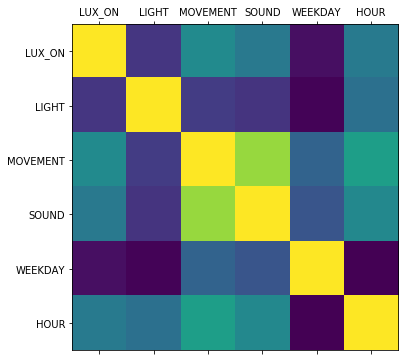

In [21]:
plot_corr(df_events)

In [22]:
df_events.corr().style.bar(subset=['LUX_ON'], color='#d65f5f', axis=0)

,LUX_ON,LIGHT,MOVEMENT,SOUND,WEEKDAY,HOUR
LUX_ON,1,0.160313,0.481136,0.406332,0.0405894,0.413593
LIGHT,0.160313,1,0.177299,0.151459,0.00983431,0.370608
MOVEMENT,0.481136,0.177299,1,0.844207,0.318614,0.562068
SOUND,0.406332,0.151459,0.844207,1,0.265185,0.468079
WEEKDAY,0.0405894,0.00983431,0.318614,0.265185,1,0.00128342
HOUR,0.413593,0.370608,0.562068,0.468079,0.00128342,1


Debido a que no se puede ver una relación fuerte entre LUX_ON y el resto de los atributos, se procede a construir otro dataset a partir del obtenido con variables más significativas.

### Generación de nuevas variables
Se analizará la relación del estado de la luz (LUX_ON) con variables dependientes del dataset generado. El objetivo es intentar representar relaciones más adecuadas con el entorno tanto a nivel espacial como temporal.
Las mediciones (facts) a construir son:
- LIGHT_1m    medición de luz en el último minuto (sin contar la medición actual)
- MOVEMENT_1m     proporción del sensor PIR activado en el último minuto
- MOVEMENT_5m     proporción del sensor PIR activado en los últimos 5 minutos
- MOVEMENT_15m    proporción del sensor PIR activado en los últimos 15 minutos

Se sumarán al dataset actual manteniendo las dimensiones y mediciones previas:
- WEEKDAY
- HOUR
- SOUND
- MOVEMENT
- LIGHT
- LUX_ON

In [96]:
df_events['LIGHT_1m'] = df_events.LIGHT.shift(1)
df_events['MOVEMENT_CHANGE'] = df_events.MOVEMENT.diff()
df_events['MOVEMENT_1m'] = df_events.MOVEMENT.shift(1)
df_events['MOVEMENT_5m'] = df_events.MOVEMENT.rolling(5).sum() / 5
df_events['MOVEMENT_15m'] = df_events.MOVEMENT.rolling(15).sum() / 15
df_events['LUX_SWITCH'] = df_events.LUX_ON.diff()
df_events['LIGHT_LAST_STATE'] = df_events.query('LUX_SWITCH != 0').LIGHT_1m
df_events['LIGHT_LAST_STATE'] = df_events['LIGHT_LAST_STATE'].fillna(method='pad')
df_events.dropna(inplace=True)

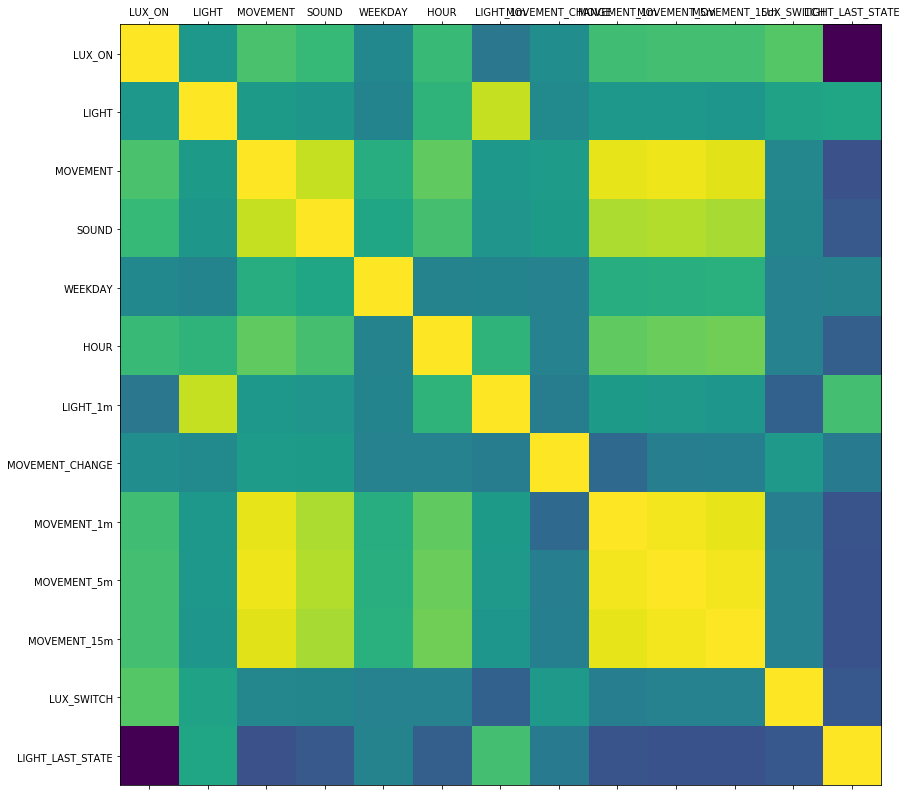

In [52]:
plot_corr(df_events,14)

In [53]:
df_events.corr().style.bar(subset=['LUX_ON'], color='#d65f5f', axis=0)

,LUX_ON,LIGHT,MOVEMENT,SOUND,WEEKDAY,HOUR,LIGHT_1m,MOVEMENT_CHANGE,MOVEMENT_1m,MOVEMENT_5m,MOVEMENT_15m,LUX_SWITCH,LIGHT_LAST_STATE
LUX_ON,1,0.160249,0.481026,0.406209,0.0406035,0.413485,-0.0895628,0.0846156,0.449868,0.464482,0.458555,0.522614,-0.801197
LIGHT,0.160249,1,0.177382,0.151519,0.00983508,0.370798,0.84144,0.0507963,0.158677,0.161098,0.144314,0.239984,0.265109
MOVEMENT,0.481026,0.177382,1,0.844199,0.318667,0.56197,0.162703,0.184114,0.932204,0.955299,0.921762,0.0305908,-0.356745
SOUND,0.406209,0.151519,0.844199,1,0.265229,0.467985,0.137769,0.182487,0.777002,0.794425,0.76759,0.028995,-0.299683
WEEKDAY,0.0406035,0.00983508,0.318667,0.265229,1,0.00128386,0.00984191,-4.30681e-05,0.318683,0.330735,0.339787,-9.89697e-06,0.00110829
HOUR,0.413485,0.370798,0.56197,0.467985,0.00128386,1,0.373771,-0.00456052,0.56365,0.586696,0.611253,-0.00050028,-0.253691
LIGHT_1m,-0.0895628,0.84144,0.162703,0.137769,0.00984191,0.373771,1,-0.0398618,0.177381,0.165674,0.147718,-0.239002,0.459185
MOVEMENT_CHANGE,0.0846156,0.0507963,0.184114,0.182487,-4.30681e-05,-0.00456052,-0.0398618,1,-0.184114,-0.0340731,-0.0224207,0.16403,-0.0559213
MOVEMENT_1m,0.449868,0.158677,0.932204,0.777002,0.318683,0.56365,0.177381,-0.184114,1,0.967845,0.930018,-0.0298096,-0.336153
MOVEMENT_5m,0.464482,0.161098,0.955299,0.794425,0.330735,0.586696,0.165674,-0.0340731,0.967845,1,0.969655,-0.00414751,-0.347956


## Entrenamiento y verificación de RNA

### Modelo #1 - Variable objetivo: estado de la lámpara (LUX_ON)
La variable a predecir es LUX_ON, la cual está en 1 si la luz está prendida (sea estado override o no del módulo). La distribución del estado en porcentaje es la siguiente:

In [80]:
df_events.LUX_ON.value_counts(normalize=True)

0    0.83518
1    0.16482
Name: LUX_ON, dtype: float64

#### Separando los datos para training y prueba
Para poder hacer etapas de entrenamiento y prueba, voy a separar los datos. 70% para entrenamiento, 30% para prueba. Para esto voy a usar del módulo scikit-learn la función train_test_split.

Los conjuntos de datos van a llamarse:
* X_train: Datos de entrenamiento. Las 7 columnas con los valores del mes, día, sensores, etc, compuesto por el 70% de los registros
* y_train: Resultado de entrenamiento. Columna *estadoLuz* para el 70% de los registros
* X_test: Datos para hacer la validación. Tienen el mismo formato que X_train, pero corresponden al 30% del conjunto de datos
* y_test: Resultados para validar la performance del algoritmo aplicado a X_test

In [81]:
from sklearn.model_selection import train_test_split

luxState_feature_names = ['WEEKDAY', 'HOUR', 'LIGHT_1m', 'SOUND', 'MOVEMENT', 'MOVEMENT_1m', 'MOVEMENT_5m', 'MOVEMENT_15m', 'LIGHT_LAST_STATE']
luxState_goal_names = ['LUX_ON']

luxState_features = df_events[luxState_feature_names].values     # Columnas del predictor (5 X m)
luxState_goal = df_events[luxState_goal_names].values            # Clase predecida (1=verdadero, 0=falso) column (1 X m)
split_test_size = 0.30                                           # 0.30 es 30%, el tamaño para pruebas

luxState_features_train, luxState_features_test, luxState_goal_train, luxState_goal_test = train_test_split(luxState_features, luxState_goal, test_size=split_test_size)

Verifico que el tamaño relativo de los sets de entrenamiento y prueba sea lo más cercano a 70-30 posible:

In [82]:
print("{0:.2f}% en el set de entrenamiento".format( (float(len(luxState_features_train))/len(df_events.index)) * 100 ) )
print("{0:.2f}% en el set de prueba".format((float(len(luxState_features_test))/len(df_events.index)) * 100))

70.00% en el set de entrenamiento
30.00% en el set de prueba


Verifico que la proporción de casos verdaderos y falsos se mantenga en los conjuntos de entrenamiento y test:

In [83]:
print("Lux Activo en el total           : {0} ({1:0.2f}%)".format(len(df_events.loc[df_events['LUX_ON'] == 1]), (len(df_events.loc[df_events['LUX_ON'] == 1])/float(len(df_events.index))) * 100.0))
print("Lux Inactivo en el total         : {0} ({1:0.2f}%)".format(len(df_events.loc[df_events['LUX_ON'] == 0]), (len(df_events.loc[df_events['LUX_ON'] == 0])/float(len(df_events.index))) * 100.0))
print("")
train_state_on = len(luxState_goal_train[ luxState_goal_train == 1])
train_state_off = len(luxState_goal_train[ luxState_goal_train == 0])
print("Lux Activo en entrenamiento      : {0} ({1:0.2f}%)".format(train_state_on, train_state_on/float(len(luxState_goal_train)) * 100.0))
print("Lux Inctivo en entrenamiento     : {0} ({1:0.2f}%)".format(train_state_off, train_state_off/float(len(luxState_goal_train)) * 100.0))
print("")
test_state_on = len(luxState_goal_test[ luxState_goal_test == 1])
test_state_off = len(luxState_goal_test[ luxState_goal_test == 0])
print("Lux Activo en test               : {0} ({1:0.2f}%)".format(test_state_on, test_state_on/float(len(luxState_goal_test)) * 100.0))
print("Lux Inctivo en test              : {0} ({1:0.2f}%)".format(test_state_off,test_state_off/float(len(luxState_goal_test)) * 100.0))

Lux Activo en el total           : 21356 (16.48%)
Lux Inactivo en el total         : 108216 (83.52%)

Lux Activo en entrenamiento      : 14937 (16.47%)
Lux Inctivo en entrenamiento     : 75763 (83.53%)

Lux Activo en test               : 6419 (16.51%)
Lux Inctivo en test              : 32453 (83.49%)


#### Entrenamiento inicial
Para este entrenamiento voy a usar otro módulo de scikit-learn: neural_network. Como lo que estamos tratando de averiguar es si la luz debe estar prendida o no, estamos hablando de un algoritmo de clasificación, y por lo tanto la función que voy a usar se llama MLPClassifier, e implementa un perceptrón multi capa (MLP) que se entrena usando backpropagation.


In [84]:
from sklearn.neural_network import MLPClassifier
clf_model_state = MLPClassifier()
%time clf_model_state.fit(luxState_features_train, luxState_goal_train.ravel())

Wall time: 4.58 s


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

#### Performance usando los datos de entrenamiento
Para esto voy a importar la función metrics.

In [85]:
from sklearn import metrics

clf_predict_state_train = clf_model_state.predict(luxState_features_train)

print("Precisión en entrenamiento: {0:.4f}".format(metrics.accuracy_score(luxState_goal_train, clf_predict_state_train)))

Precisión en entrenamiento: 0.9790


#### Performance usando los datos de prueba

In [86]:
clf_predict_state_test = clf_model_state.predict(luxState_features_test)

print("Precisión en test: {0:.4f}".format(metrics.accuracy_score(luxState_goal_test, clf_predict_state_test)))

Precisión en test: 0.9778


#### Métricas
Los resultados de las etapas de entrenamiento y prueba son muy buenos. Demasiado buenos. Hay que analizar si no hay algún otro problema que pueda causar que cuando ponga más datos (cuando analice en tiempo real la actividad del usuario), el modelo falle miserablemente.

Para este análisis, voy a ver como se comparan los resultados, con el objetivo de entender si el modelo sirve o hay que hacer ajustes. Voy a usar dos herramientas:

##### Matriz de confusión
https://es.wikipedia.org/wiki/Matriz_de_confusi%C3%B3n

Cada columna de la matriz representa el número de predicciones de cada clase, mientras que cada fila representa a las instancias en la clase real. Uno de los beneficios de las matrices de confusión es que facilitan ver si el sistema está confundiendo dos clases. 

En nuestro caso, la matriz representa lo siguiente:


| EV (Predicho Encendido y es verdad ) | EF (Predicho Encendido pero es falso) |
|------------------------------------------------|
| **AF (Predicho Apagado pero es Falso** | **AV (Predicho Apagado y es verdad)** |

Esto quiere decir que queremos los valores más altos posibles en la diagonal, y lo más cerca posible a cero en cualquier otro lado.

In [87]:
print("Matriz de confusión:")
print("{0}".format(metrics.confusion_matrix(luxState_goal_test, clf_predict_state_test, labels=[1, 0])))

Matriz de confusión:
[[ 5611   808]
 [   56 32397]]


Estos resultados son muy buenos, el porcentaje de acertados es altísimo. El modelo es casi perfecto. Para confirmar, hay que usar la otra herramienta.


#### Reporte de clasificación.
Lo primero que vamos a verificar es que tan bien se hace una predición acertada cuando se requiere que el dispositivo esté encendido. Este dato, llamado "recall" en el reporte, esta dado por:

Recall = EV / (EV + AF)

Lo segundo que queremos ver es la presición, que está dada por:

Precision = EV / (EV + EF)


In [88]:
print("Reporte de clasificación:")
print(metrics.classification_report(luxState_goal_test, clf_predict_state_test, labels=[1,0]))

Reporte de clasificación:
             precision    recall  f1-score   support

          1       0.99      0.87      0.93      6419
          0       0.98      1.00      0.99     32453

avg / total       0.98      0.98      0.98     38872



### Modelo #2 - Variable objetivo: cambio de estado de la lámpara (LUX_SWITCH)
La variable a predecir es LUX_SWITCH que se describe como cada cambio de estado del lux.
-  1: la luz se prendió
-  0: no hubo cambios
- -1: la luz se apagó
La distribución del estado en porcentaje es la siguiente:

In [59]:
df_events.LUX_SWITCH.value_counts(normalize=True)

 0.0    0.849613
 1.0    0.075194
-1.0    0.075194
Name: LUX_SWITCH, dtype: float64

#### Separando los datos para training y prueba

In [89]:
luxSwitch_feature_names = ['WEEKDAY', 'HOUR', 'LIGHT_1m', 'SOUND', 'MOVEMENT', 'MOVEMENT_1m', 'MOVEMENT_5m', 'MOVEMENT_15m', 'LIGHT_LAST_STATE' ]
luxSwitch_goal_names = ['LUX_SWITCH']

luxSwitch_features = df_events[luxSwitch_feature_names].values        # Columnas predictoras
luxSwitch_goal = df_events[luxSwitch_goal_names].values               # Clase predecida (1, 0, -1)
split_test_size = 0.30                                                # 0.30 es 30%, el tamaño para pruebas

luxSwitch_feat_train, luxSwitch_feat_test, luxSwitch_goal_train, luxSwitch_goal_test = train_test_split(luxSwitch_features, luxSwitch_goal, test_size=split_test_size)

In [71]:
print("{0:.2f}% en el set de entrenamiento".format( (float(len(luxSwitch_feat_train))/len(df_events.index)) * 100 ) )
print("{0:.2f}% en el set de prueba".format((float(len(luxSwitch_feat_test))/len(df_events.index)) * 100))

70.00% en el set de entrenamiento
30.00% en el set de prueba


In [72]:
totales_switch_on = len(df_events.query('LUX_SWITCH == 1'))
totales_switch_stale = len(df_events.query('LUX_SWITCH == 0'))
totales_switch_off = len(df_events.query('LUX_SWITCH == -1'))
print('Totales:')
print("Prendidas        : {0} ({1:0.2f}%)".format(totales_switch_on, totales_switch_on/float(df_events.shape[0]) * 100.0))
print("Sin cambios      : {0} ({1:0.2f}%)".format(totales_switch_stale, totales_switch_stale/float(df_events.shape[0]) * 100.0))
print("Apagadas         : {0} ({1:0.2f}%)".format(totales_switch_off, totales_switch_off/float(df_events.shape[0]) * 100.0))
print('')
train_switch_on = len(luxSwitch_goal_train[ luxSwitch_goal_train == 1])
train_switch_stale = len(luxSwitch_goal_train[ luxSwitch_goal_train == 0])
train_switch_off = len(luxSwitch_goal_train[ luxSwitch_goal_train == -1])
print('Set de entrenamiento:')
print("Prendidas        : {0} ({1:0.2f}%)".format(train_switch_on, train_switch_on/float(luxSwitch_goal_train.shape[0]) * 100.0))
print("Sin cambios      : {0} ({1:0.2f}%)".format(train_switch_stale, train_switch_stale/float(luxSwitch_goal_train.shape[0]) * 100.0))
print("Apagadas         : {0} ({1:0.2f}%)".format(train_switch_off, train_switch_off/float(luxSwitch_goal_train.shape[0]) * 100.0))
print('')
test_switch_on = len(luxSwitch_goal_test[ luxSwitch_goal_test == 1])
test_switch_stale = len(luxSwitch_goal_test[ luxSwitch_goal_test == 0])
test_switch_off = len(luxSwitch_goal_test[ luxSwitch_goal_test == -1])
print('Set de pruebas:')
print("Prendidas        : {0} ({1:0.2f}%)".format(test_switch_on, test_switch_on/float(luxSwitch_goal_test.shape[0]) * 100.0))
print("Sin cambios      : {0} ({1:0.2f}%)".format(test_switch_stale, test_switch_stale/float(luxSwitch_goal_test.shape[0]) * 100.0))
print("Apagadas         : {0} ({1:0.2f}%)".format(test_switch_off, test_switch_off/float(luxSwitch_goal_test.shape[0]) * 100.0))

Totales:
Prendidas        : 9743 (7.52%)
Sin cambios      : 110086 (84.96%)
Apagadas         : 9743 (7.52%)

Set de entrenamiento:
Prendidas        : 6915 (7.62%)
Sin cambios      : 77057 (84.96%)
Apagadas         : 6728 (7.42%)

Set de pruebas:
Prendidas        : 2828 (7.28%)
Sin cambios      : 33029 (84.97%)
Apagadas         : 3015 (7.76%)


#### Entrenamiento inicial

In [90]:
clf_model_switch = MLPClassifier()
%time clf_model_switch.fit(luxSwitch_feat_train, luxSwitch_goal_train.ravel())

Wall time: 6.85 s


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

#### Performance usando los datos de entrenamiento

In [91]:
clf_predict_switch_train = clf_model_switch.predict(luxSwitch_feat_train)

print("Precisión en entrenamiento: {0:.4f}".format(metrics.accuracy_score(luxSwitch_goal_train, clf_predict_switch_train)))

Precisión en entrenamiento: 0.9635


#### Performance usando los datos de prueba

In [92]:
clf_predict_switch_test = clf_model_switch.predict(luxSwitch_feat_test)

print("Precisión en test: {0:.4f}".format(metrics.accuracy_score(luxSwitch_goal_test, clf_predict_switch_test)))

Precisión en test: 0.9631


#### Métricas
##### Matriz de confusión

In [93]:
matriz_conf = metrics.confusion_matrix(luxSwitch_goal_test, clf_predict_switch_test, labels=[1, 0, -1])
print("{0}".format(matriz_conf))

[[ 2377   276   250]
 [   63 32862   154]
 [  255   437  2198]]


In [94]:
# Porcentaje de acierto
matriz_conf.diagonal().sum() / float(matriz_conf.sum()) * 100

96.308396789462861

#### Reporte de clasificación

In [95]:
print(metrics.classification_report(luxSwitch_goal_test, clf_predict_switch_test, labels=[1,0,-1]))

             precision    recall  f1-score   support

          1       0.88      0.82      0.85      2903
          0       0.98      0.99      0.99     33079
         -1       0.84      0.76      0.80      2890

avg / total       0.96      0.96      0.96     38872



## Validación del modelo

### Predicción de ESTADO (LUX_ON)
Features:

| WEEKDAY | MINDAY | LIGHT_LUX_1m | SOUND | MOVEMENT | MOVEMENT_1m | MOVEMENT_5m | MOVEMENT_15m |
|-----------------------------------------------------------------------------------------------|
| 0-6 | 0-1439 | 0-2000 | 30-130 | 0/1 | 0-1 | 0-1 | 0-1 |

In [50]:
X_new_test = pd.DataFrame([[ 5, 670, 85, 50, 1, 1, 1, 0.9 ]],columns=luxState_feature_names)

In [51]:
clf_predict_new_test = clf_model_state.predict(X_new_test)

print ("Resultado: ", clf_predict_new_test)

Resultado:  [0]


### Predicción de CAMBIO DE ESTADO (LUX_SWITCH)

Features:

| WEEKDAY | MINDAY | LIGHT_LUX_1m | SOUND | MOVEMENT | MOVEMENT_1m | MOVEMENT_5m | MOVEMENT_15m |
|-----------------------------------------------------------------------------------------------|
| 0-6 | 0-1439 | 0-2000 | 30-130 | 0/1 | 0-1 | 0-1 | 0-1 |

In [52]:
X_new_test = pd.DataFrame([[ 5, 670, 85, 50, 1, 1, 1, 0.9 ]],columns=luxSwitch_feature_names)

In [53]:
clf_predict_new_test = clf_model_switch.predict(X_new_test)

print ("Resultado: ", clf_predict_new_test)

Resultado:  [ 0.]
